In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.optimize import least_squares as lsq
from scipy.stats import gaussian_kde
import random
random.seed(4321)
np.random.seed(1234)

In [2]:
NewDF = pd.read_csv("AnalysisData010532_comma.csv")

In [3]:
NewDF.head(20)

,NGA,PolID,Time,SPC1,RelTime,Preceeding.Relation,Keep,Note
0,Cambodian Basin,KhFunaE,300,0.673646,0,continuity,YES,NaN
1,Cambodian Basin,KhFunaE,400,0.673646,100,continuity,YES,NaN
2,Cambodian Basin,KhFunaE,500,0.673646,200,continuity,YES,NaN
3,Cambodian Basin,KhFunaL,600,0.664762,300,continuity,YES,NaN
4,Cambodian Basin,KhChenl,700,0.753940,400,continuity,YES,NaN
5,Cambodian Basin,KhChenl,800,0.783000,500,continuity,YES,NaN
6,Cambodian Basin,KhAngkE,900,0.844609,600,continuity,YES,NaN
7,Cambodian Basin,KhAngkE,1000,0.828656,700,continuity,YES,NaN
8,Cambodian Basin,KhAngkC,1100,0.840909,800,continuity,YES,NaN
9,Cambodian Basin,KhAngkC,1200,0.840909,900,continuity,YES,NaN


In [4]:
PolRel = pd.read_excel("Seshat_PolityRelationData.xlsx")
Data = pd.read_csv("Seshat Data.csv")
Parameters_and_Times = np.loadtxt("Parameters_and_Times.txt")
RelTimeDF = pd.read_csv("RelTime_TimeSeries_SPC1.csv", index_col = 0)
RelTimeCCDF = pd.read_csv("RelTime_TimeSeries_CC.csv")
del RelTimeCCDF["Unnamed: 0"]
Parameters = Parameters_and_Times[:4]
Times = Parameters_and_Times[4:]
T = 5000

In [5]:
def f(x, a, b, c, d):
    # the logistic function in its most general shape, scaled by T=5000
    return a / (1. + np.exp(-c * (x - d))) + b


def RhoSq(y_hat, y_true): # like in Turchin's original PCA paper
    y_mean = np.mean(y_true)
    return(1 - sum((y_hat-y_true)**2)/sum((y_mean-y_true)**2)  )

# Visualise


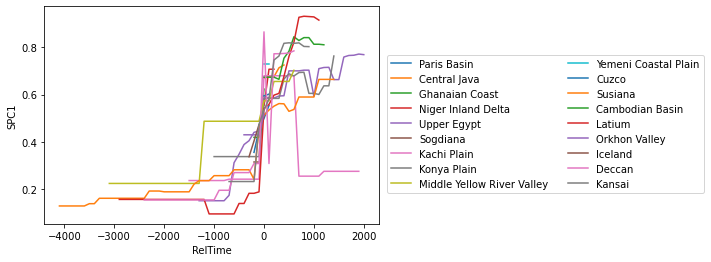

In [6]:
KeptDF = NewDF.query("Keep == 'YES'")
KeptDF.head()

for n in set(KeptDF["NGA"]):
    ngaDF = KeptDF.query("NGA == @n")
    plt.plot(ngaDF.RelTime, ngaDF.SPC1, label=n)
plt.xlabel("RelTime")
plt.ylabel("SPC1")
plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)    
plt.show()
    

# Fitting

In [7]:
X, y = KeptDF["RelTime"].to_numpy(), KeptDF["SPC1"].to_numpy()
T = 5000
X = np.array(list(X)) # for some reason, this transformation is necessary
X = X/T # normalisation of the data

def f(x, a, b, c, d):
    # the logistic function in its most general shape
    return a / (1. + np.exp(-c * (x - d))) + b

(a_, b_, c_, d_), _ = opt.curve_fit(f, 
                                    X, 
                                    y, #
                                    p0 = Parameters)

P0 = np.array((a_, b_, c_, d_))
print(P0)

[ 4.49156925e-01  2.11693710e-01  4.22448817e+01 -2.52281354e-02]


In [8]:
# Previous Cutouts:

# [ 4.76748566e-01  2.11587418e-01  4.39930347e+01 -2.25088978e-02]

# comparison with full data:
Parameters

array([ 5.91641013e-01,  1.93784865e-01,  1.93749265e+01, -1.54321380e-02])

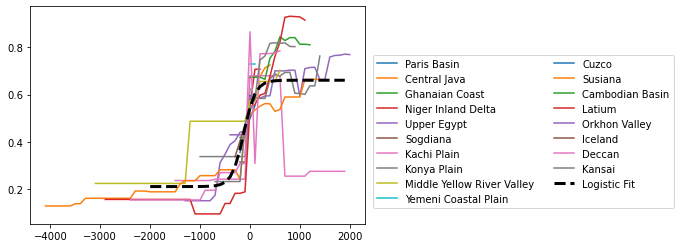

In [9]:
for n in list(set(KeptDF["NGA"])):
    smalldf = KeptDF.query("NGA == @n") 
    #print(smalldf)
    plt.plot(smalldf["RelTime"], smalldf["SPC1"], label=n)

TimeRange = np.arange(-2000,2000,100)
New_Fit = f(TimeRange/T, a_, b_, c_, d_)
plt.plot(TimeRange, New_Fit, "--",label="Logistic Fit", c="k", linewidth = 3)
plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)
plt.show()

## Out-of-Sample prediction
To evaluate quality of the fit.

In [10]:
L = len(X)

0.7069222233314126 0.7119104241371708 0.03932504049852569


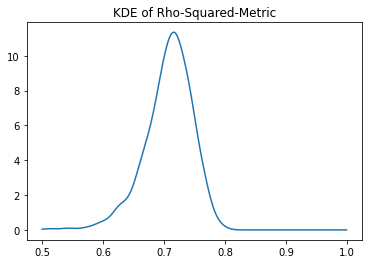

In [11]:
C_list = list()
RhoSqList = list()
n_split = 1000
for i in range(1000):
    
    Selection = np.random.choice(np.arange(L), size = int(L/2), replace = False)
    
    X_train = X[Selection]
    y_train = y[Selection]
    
    test_indx = np.ones(len(X), bool)
    test_indx[Selection]=0
    y_test = y[test_indx]
    X_test = X[test_indx]
    
    (a1_, b1_, c1_, d1_), _ = opt.curve_fit(f, X_train, y_train,
                                            p0 = Parameters) # initial guess to ensure c > 0
    #print((a1_, b1_, c1_, d1_))
    C_list.append(c1_)
    RhoSqList.append(RhoSq( f(X_test, a1_, b1_, c1_, d1_), y_test))
    
print(np.mean(RhoSqList), np.median(RhoSqList), np.std(RhoSqList))

plt.plot(np.arange(0.5,1,0.001),
    gaussian_kde(RhoSqList)(np.arange(0.5,1,0.001)))
plt.title("KDE of Rho-Squared-Metric")
plt.show()

## Bootstrapping

First round of bootstrap: estimate many parameter values for a and b and the standard deviations for a, b a+b. This allows to compute the thresholds of the plateaus.

In [12]:
np.random.seed(1234)
random.seed(1234)
nBT = 1000 # how many Bootstraps

Params = pd.DataFrame(columns = ["a", "b", "c", "d"]) # df of the parameters
NGA_list = list(set(KeptDF["NGA"]))


for i in range(nBT):
    NGA_selection = random.choices(NGA_list,k=len(NGA_list))
    Data_Bootstrap = pd.DataFrame(columns = KeptDF.columns)

    for n in NGA_selection:
        Data_Bootstrap = pd.concat([Data_Bootstrap, KeptDF[KeptDF["NGA"]==n]])
    
    
    X, y = Data_Bootstrap["RelTime"].to_numpy(), Data_Bootstrap["SPC1"].to_numpy()

    X = np.array(list(X)) # for some reason, this transformation is necessary
    X = X/T # normalisation of the data
    (a_, b_, c_, d_), _ = opt.curve_fit(f, X, y, P0) # p0: Initial guess = Full Estimation
                                                     # Otherwise: direction can reverse with c<0

    Params = pd.concat([Params,
                       pd.DataFrame(data={"a":[a_], "b":[b_], "c":[c_], "d":[d_]})])

        
    #print(a_, b_, c_, d_)
    #print("-----------------")
print(Params.round(2))

C:\Users\Tobias\AppData\Local\Temp/ipykernel_24712/1560987097.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


       a     b       c     d
0   0.47  0.19   41.15 -0.03
0   0.43  0.22   17.98 -0.07
0   0.43  0.22   49.96 -0.02
0   0.23  0.28   54.51 -0.04
0   0.43  0.20   23.13 -0.05
..   ...   ...     ...   ...
0   0.37  0.25   85.19 -0.02
0   0.48  0.19   42.01 -0.03
0   0.44  0.22   37.97 -0.03
0   0.42  0.18  761.68 -0.02
0   0.45  0.21   22.77 -0.04

[1000 rows x 4 columns]


Mean 0.46783133282771494  and Median 0.46224987890942165
50% centred quantiles 0.4105062270317613 0.5333162405558483
90% centred quantiles 0.33154764332824893 0.5934316379555469


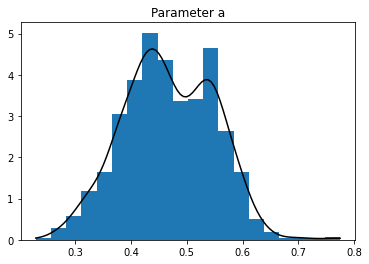

Mean 0.20921701349432179  and Median 0.20474176974292468
50% centred quantiles 0.18948609745440806 0.2257291966559651
90% centred quantiles 0.16903711344473277 0.2633776093557669


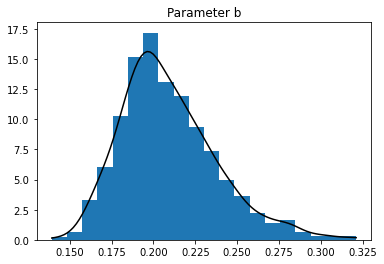

Mean 97.18967389326997  and Median 36.84465217108457
50% centred quantiles 25.350057022970734 59.38855053452047
90% centred quantiles 16.699888762334382 806.6035149007995


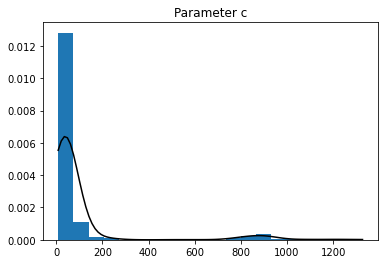

Mean -0.024151745856062983  and Median -0.022815552406059158
50% centred quantiles -0.028537814848799817 -0.01855865871428353
90% centred quantiles -0.0405530963928187 -0.010887186357922688


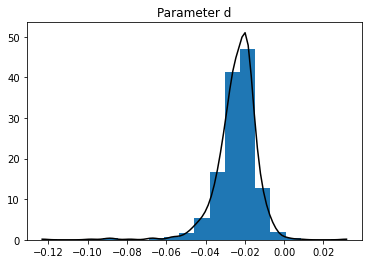

In [13]:
for P in Params.columns:
    
    
    Ps = Params[P]
    P_range = np.linspace(min(Ps), max(Ps),100)
    KDE = gaussian_kde(Ps)(P_range)
    print("Mean", np.mean(Ps), " and Median", np.median(Ps))
    print("50% centred quantiles", np.quantile(Ps, 0.25), 
          np.quantile(Ps, 0.75))
    print("90% centred quantiles", np.quantile(Ps, 0.05), 
          np.quantile(Ps, 0.95))
    plt.hist(Ps,bins=20, density= True)
    plt.plot(P_range, KDE, c="k")
    plt.title("Parameter "+str(P))
    plt.show()

### Analysis of the Curve

When does f(x) = y_est actually change? 
f(-infinity) = b and f(infinity) = a + b. We can now calculate the standard deviations of b and a+b via the bootstrap estimations and check when y_est exceeds b + sd(b) and reaches a+b - sd(a+b).

In [14]:
print("b",np.mean(Params["b"]), np.std(Params["b"]))
print("a+b",np.mean(Params["b"]+Params["a"]), np.std(Params["b"]+Params["a"]))

Thresh1 = np.mean(Params["b"]) + np.std(Params["b"])
Thresh2 = np.mean(Params["b"]+Params["a"]) - np.std(Params["b"]+Params["a"])
print("Thresholds",Thresh1, Thresh2)

def f1(x):
    # first threshold
    return(f(x, P0[0], P0[1], P0[2], P0[3])-Thresh1)

T1 = opt.root(f1, -0.5)

def f2(x):
    # second threshold
    return(f(x, P0[0], P0[1], P0[2], P0[3])-Thresh2)

T2 = opt.root(f2, 0.5)

b 0.20921701349432179 0.028585965650716774
a+b 0.6770483463220365 0.06446781156430524
Thresholds 0.23780297914503856 0.6125805347577312


C:\Users\Tobias\AppData\Local\Temp/ipykernel_24712/1560987097.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


In [15]:
Timeframe = (T2["x"] -T1["x"])[0]
t_2, t_1 = T2["x"], T1["x"]
# scale this back to original time
print("Most of the cultural evolution takes place in a time interval of ", np.round(T*Timeframe), "years.")

Most of the cultural evolution takes place in a time interval of  1578.0 years.


## Bootstrapping the Time Interval

Now we can repeat this task, but 

-> Calculate the time thresholds T1/T2 for every single Bootstrapped Data and therefore calculate a time interval with standard deviation

In [16]:
def fBT1(x):
    # first threshold for the Bootstrapping
    return(f(x, a_, b_, c_, d_)-Thresh1)

def fBT2(x):
    # second threshold for the Bootstrapping
    return(f(x, a_, b_, c_, d_)-Thresh2)


In [17]:
np.random.seed(1234)
random.seed(1234)
nBT = 1000 # how many Bootstraps
Successes = 0

Params2 = pd.DataFrame(columns = ["a", "b", "c", "d"]) # df of the parameters

for i in range(nBT):
    
    # Select the random NGAs
    NGA_selection = random.choices(NGA_list,k=len(NGA_list))
    Data_Bootstrap = pd.DataFrame(columns = KeptDF.columns)

    for n in NGA_selection: # combine them to a data frame
        Data_Bootstrap = pd.concat([Data_Bootstrap, KeptDF[KeptDF["NGA"]==n]])
    
    
    X, y = Data_Bootstrap["RelTime"].to_numpy(), Data_Bootstrap["SPC1"].to_numpy()

    X = np.array(list(X)) # for some reason, this transformation is necessary
    X = X/T # normalisation of the data
    (a_, b_, c_, d_), _ = opt.curve_fit(f, X, y, P0) # p0: Initial guess = Full Estimation
                                                     # Otherwise: direction can reverse with c<0
    
    # Time Intervals
    T1 = opt.root(fBT1, t_1)
    T2 = opt.root(fBT2, t_2)
    
    # only add results, if opt.root is successful:
    if T1["success"] and T2["success"]:
        Successes += 1
        Params2 = pd.concat([Params2,
                       pd.DataFrame(data={"a":[a_], "b":[b_], "c":[c_], "d":[d_], "T1":T1["x"], "T2":T2["x"]})])    
        #print(a_, b_, c_, d_, T1, T2)
        #print("-----------------")


C:\Users\Tobias\AppData\Local\Temp/ipykernel_24712/1560987097.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


In [18]:
print(Successes)
print(Params2.round(2))

724
       a     b      c     d    T1    T2
0   0.47  0.19  41.15 -0.03 -0.08  0.03
0   0.43  0.22  17.98 -0.07 -0.24  0.06
0   0.43  0.22  49.96 -0.02 -0.08  0.03
0   0.43  0.20  23.13 -0.05 -0.15  0.09
0   0.52  0.24  28.02 -0.02 -0.26  0.02
..   ...   ...    ...   ...   ...   ...
0   0.52  0.18  32.66 -0.02 -0.09  0.03
0   0.41  0.23  51.03 -0.02 -0.11  0.03
0   0.48  0.19  42.01 -0.03 -0.08  0.02
0   0.44  0.22  37.97 -0.03 -0.12  0.02
0   0.45  0.21  22.77 -0.04 -0.16  0.05

[724 rows x 6 columns]


In [19]:
T2_scaled, T1_scaled = np.mean(Params2["T2"])*T, T*np.mean(Params2["T1"])

T1_start_scaled = T*np.mean(Params2["T1"]) - T*np.std(Params2["T1"])
T2_end_scaled = T*np.mean(Params2["T2"]) + T*np.std(Params2["T2"])

TimeframeBT = Params2["T2"]-Params2["T1"]
print(np.mean(TimeframeBT))

# times T for the transformation to years


0.148262669605925


Cambodian Basin
Central Java
Cuzco
Deccan
Ghanaian Coast
Iceland
Kachi Plain
Kansai
Konya Plain
Latium
Middle Yellow River Valley
Niger Inland Delta
Orkhon Valley
Paris Basin
Sogdiana
Susiana
Upper Egypt
Yemeni Coastal Plain


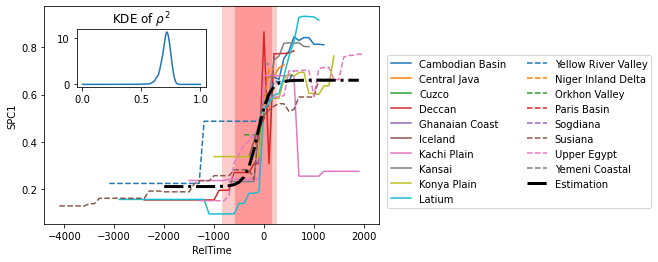

In [20]:
fig, ax1 = plt.subplots()

DF_Out_cutout = pd.DataFrame(columns=["NGA","RelTime","SPC1"])


# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.2, 0.6, 0.3, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])
style ="-"

for N in sorted(list(set(KeptDF["NGA"]))):
    DF = KeptDF[KeptDF["NGA"] == N]

      # some abbreviations
    if N=="Middle Yellow River Valley":
        name = "Yellow River Valley"
    elif N == "Yemeni Coastal Plain":
        name = "Yemeni Coastal"
    else:
        name = N
        
    print(N)
    #print(DF["RelTime"])
    ax1.plot(DF["RelTime"],   
             DF["SPC1"], style,label=name)
    DF_Out_cutout = pd.concat((DF_Out_cutout, DF[["NGA", "RelTime", "SPC1"]]))
    if N == "Latium":
        style = "--"
    
ax1.plot(TimeRange, New_Fit, "-.",label="Estimation", c = "k", linewidth=3)
lgd = ax1.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)
ax1.set_ylabel("SPC1")
ax1.set_xlabel("RelTime")
ax1.axvspan(T1_scaled, T2_scaled, facecolor='r', alpha=0.4)
ax1.axvspan(T2_scaled, T2_end_scaled, facecolor='r', alpha=0.2)
ax1.axvspan(T1_start_scaled, T1_scaled, facecolor='r', alpha=0.2)

ax2.plot(np.arange(0.0,1,0.001),
    gaussian_kde(RhoSqList)(np.arange(0.0,1,0.001)))
ax2.set_title(r'KDE of $\rho^2$')

plt.savefig("KeptDF_Logistic_Times_Inset.pdf",bbox_extra_artists=(lgd,),dpi=300,bbox_inches='tight')
plt.show()

In [21]:

print("Most of the cultural evolution takes place in a time interval of ", np.round(T*np.mean(TimeframeBT)), 
      "years. The interval's start and end times are", np.round(T1_scaled), "and", np.round(T2_scaled),
      "The lower boundary's uncertainty is", np.round(T1_start_scaled), "and the upper boundary's uncertainty is", 
     np.round(T2_end_scaled), "years. Thus, the upper estimate for the time range is", np.round(T2_end_scaled-T1_start_scaled), "years.")

Most of the cultural evolution takes place in a time interval of  741.0 years. The interval's start and end times are -580.0 and 161.0 The lower boundary's uncertainty is -834.0 and the upper boundary's uncertainty is 253.0 years. Thus, the upper estimate for the time range is 1087.0 years.


## Appendix: Data Transformation for Latium

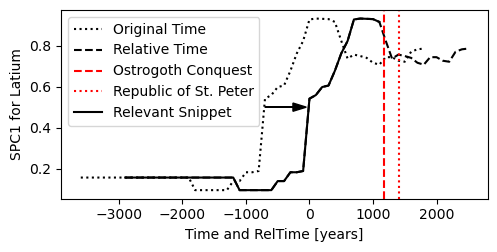

In [22]:
LatiumDF = Data.query("NGA == 'Latium'")
LatiumRT = RelTimeDF.query("NGA == 'Latium'")
LatiumKept = KeptDF.query("NGA == 'Latium'")

plt.figure(figsize =(5.5,2.5), dpi=100)
plt.plot(LatiumDF.Time, LatiumDF.SPC1,":", c = "black", label="Original Time")
plt.plot(LatiumRT.RelTime, LatiumRT.SPC1,"--" , c = "black", label = "Relative Time")

T0 = -700

plt.axvline(476 -T0,label="Ostrogoth Conquest",
                c = "red",
                linestyle = "--" )

plt.axvline(711-T0,label="Republic of St. Peter",
                c = "red",
                linestyle = ":" )

plt.plot(LatiumKept.RelTime, LatiumKept.SPC1,"-" , c = "black", label = "Relevant Snippet")

plt.arrow(x=T0, y=0.5, dx= -T0-50, dy= 0.0,
         length_includes_head = True,
         head_length = -0.3*T0,
         head_width = 0.04, fc="k")

plt.legend()

plt.xlabel("Time and RelTime [years]")
plt.ylabel("SPC1 for Latium")

plt.savefig("Latium_Discontinuities_Redone.pdf",dpi=200, bbox_inches='tight')